In [34]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import resize
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch import optim
from RdmDataset import RdmDataset
from RdmClassifier import RdmClassifier
from datetime import datetime


In [16]:
capture_frame_csv_path = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v2.csv"

root_dir = '/Volumes/FourTBLaCie/Yoga_Study_RADAR_1Ch'

all_folders = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

# Assuming all folders are named or ordered in such a way that participant data is together
# and that the sorting provides a meaningful order

num_train_folders = int(len(all_folders) * 0.7)
num_val_folders = int(len(all_folders) * 0.15)

# Remaining folders will be for testing

train_folders = all_folders[:num_train_folders]
val_folders = all_folders[num_train_folders:num_train_folders + num_val_folders]
test_folders = all_folders[num_train_folders + num_val_folders:]


# Data loader setup
def setup_loaders(root_dir, event_csv, folders):
    datasets = {x: RdmDataset(root_dir, event_csv, folders[x], window_size=100) for x in ['train', 'val', 'test']}
    loaders = {x: DataLoader(datasets[x], batch_size=2, shuffle=True if x == 'train' else False, collate_fn=RdmDataset.collate_fn) for x in datasets}
    return loaders

folders = {
    'train': train_folders,
    'val': val_folders,
    'test': test_folders
}
loaders = setup_loaders(root_dir, capture_frame_csv_path, folders)
train_loader, val_loader, test_loader = loaders['train'], loaders['val'], loaders['test']

In [17]:
print(f"Number of training samples: {len(train_loader)}")
print(f"Number of testing samples: {len(test_loader)}")
print(f"Number of val samples: {len(val_loader)}")

data, labels, length, metadata = next(iter(train_loader))
print(data.shape, labels.shape, length, metadata)


Number of training samples: 1278
Number of testing samples: 392
Number of val samples: 256
torch.Size([2, 100, 23, 13]) torch.Size([2, 100]) tensor([100, 100]) ({'frame_range': (444, 544), 'RADAR_capture': '08_MNTRR_RR_V1', 'GOUP_ranges': [(25, 37)], 'DOWN_ranges': []}, {'frame_range': (540, 640), 'RADAR_capture': '02_MNTRL_RR_V3', 'GOUP_ranges': [], 'DOWN_ranges': [(57, 73)]})


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmDataset.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = pad_sequence([torch.tensor(seq, dtype=torch.float) for seq in sequences], batch_first=True)


In [20]:
import matplotlib.pyplot as plt

def visualize_sample(data, label):
    print(data.shape)
    # Assuming your data is a 2D RADAR sequence, adjust accordingly
    # This is a simple visualization, consider plotting individual frames
    print(f"Label: {label}")
    plt.imshow(data[0], cmap='gray')  # Just visualize the first frame for simplicity
    plt.show()

# Visualize a few samples from the test set
for i in range(3):
    data, label, _, _ = next(iter(train_loader))
    visualize_sample(np.array(data), label)  # Convert to numpy if it's a tensor


ValueError: not enough values to unpack (expected 4, got 2)

In [21]:
# Initialize the model
num_classes = 3  # GOUP, BLNC, DOWN
hidden_size = 128
model = RdmClassifier(num_classes=num_classes, hidden_size=hidden_size)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
#simple test
def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0  # Keep track of total predictions for accuracy calculation

    with torch.no_grad():  # Disable gradient computation
        for data, labels, lengths, metadata in test_loader:  # Adjust to unpack lengths
            data = data.float()  # Ensure data is in float
            outputs = model(data, lengths)  # Pass both data and lengths to the model
            print(outputs)
            outputs_flat = outputs.view(-1, num_classes)  # Flatten output for loss calculation
            labels_flat = labels.view(-1)  # Flatten labels for consistency with loss calculation

            loss = criterion(outputs_flat, labels_flat)
            total_loss += loss.item()

            # Calculate predictions
            _, predicted = torch.max(outputs_flat.data, 1)

            # Update correct predictions count
            correct_predictions += (predicted == labels_flat).sum().item()
            total_predictions += labels_flat.size(0)  # Update total predictions

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_predictions  # Calculate accuracy using total predictions
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


In [37]:
# smoothing test 
import numpy as np
import torch

def test_model(model, test_loader, criterion, window_size=5):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient computation
        for data, labels, lengths, metadata in test_loader:
            data = data.float()  # Ensure data is float
            outputs = model(data, lengths)  # Pass both data and lengths to the model
            # print(outputs)
            outputs_flat = outputs.view(-1, num_classes)  # Flatten output for loss calculation
            labels_flat = labels.view(-1)

            # Convert model outputs to probabilities using softmax
            probabilities = torch.softmax(outputs_flat, dim=1).cpu().numpy()

            # Smooth probabilities for each class
            smoothed_probabilities = np.apply_along_axis(
                lambda m: np.convolve(m, np.ones(window_size)/window_size, mode='same'), 
                axis=0, 
                arr=probabilities)

            # Select the class with the highest smoothed probability for each prediction
            smoothed_predictions = np.argmax(smoothed_probabilities, axis=1)

            # Update correct predictions count
            correct_predictions += (smoothed_predictions == labels_flat.cpu().numpy()).sum()
            total_predictions += labels_flat.size(0)

            # Continue with loss calculation (using original, unsmoothed predictions)
            loss = criterion(outputs_flat, labels_flat)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_predictions  # Calculate accuracy using total predictions
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


In [23]:
def train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()  # Training mode
        train_loss = 0
        for data, labels, lengths, metadata in train_loader:
            optimizer.zero_grad()
            data = data.float()  # Ensure data is float
            outputs = model(data, lengths)
            outputs_flat = outputs.view(-1, model.num_classes)
            labels_flat = labels.view(-1)
            loss = criterion(outputs_flat, labels_flat)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)

        # Validation phase
        model.eval()  # Evaluation mode
        val_loss = 0
        with torch.no_grad():
            for data, labels, lengths, metadata in val_loader:
                data = data.float()
                outputs = model(data, lengths)
                outputs_flat = outputs.view(-1, model.num_classes)
                labels_flat = labels.view(-1)
                loss = criterion(outputs_flat, labels_flat)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


In [31]:
# Assuming train_loader and test_loader are already defined
train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmDataset.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = pad_sequence([torch.tensor(seq, dtype=torch.float) for seq in sequences], batch_first=True)


Epoch [1/5], Train Loss: 0.4747, Val Loss: 0.2515
Epoch [2/5], Train Loss: 0.2834, Val Loss: 0.1513
Epoch [3/5], Train Loss: 0.2867, Val Loss: 0.2038
Epoch [4/5], Train Loss: 0.2268, Val Loss: 0.1356
Epoch [5/5], Train Loss: 0.2115, Val Loss: 0.1351


In [35]:
model_path = f'/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/models/full_model_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pth'

# Saving the entire model (architecture + weights)
torch.save(model, model_path)

In [40]:
# Assuming the RdmClassifier class is already defined
# Instantiate the model
loaded_model = RdmClassifier(num_classes=num_classes, hidden_size=hidden_size)

# Load the saved state dict
loaded_model = torch.load(model_path)

# Make sure to call .eval() if you're doing inference to set dropout and batch normalization layers to evaluation mode
loaded_model.eval()


RdmClassifier(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (lstm): LSTM(1056, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [41]:
test_model(loaded_model, test_loader, criterion)

Test Loss: 0.2506, Accuracy: 0.9205


In [ ]:
test_model(model, test_loader, criterion)

/var/folders/nh/xjdmv90x37b3xwwbwbm5lp1w0000gn/T/ipykernel_2114/155399679.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = pad_sequence([torch.tensor(seq, dtype=torch.float) for seq in sequences], batch_first=True)


Test Loss: 0.2418, Accuracy: 0.9222


torch.Size([1, 100, 23, 13]) torch.Size([100])


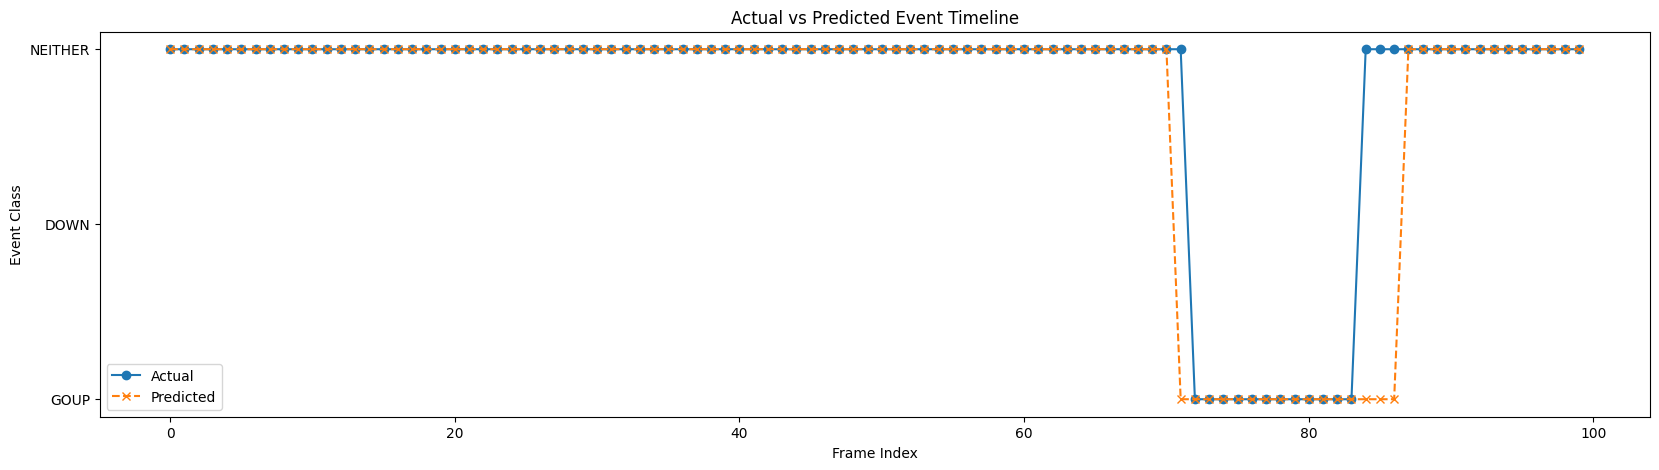

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_timeline(sample_data, model, actual_labels):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Assuming sample_data is already in the correct shape: [1, seq_len, height, width]
        # and actual_labels is a tensor of shape [seq_len]
        lengths = torch.tensor([len(sample_data[0])])  # [seq_len]
        predictions = model(sample_data, lengths)  # Get predictions from the model
        predicted_labels = torch.argmax(predictions.squeeze(), dim=1)  # Convert predictions to label indices
        
    # Convert tensors to numpy arrays for plotting
    actual_labels = actual_labels.numpy()
    predicted_labels = predicted_labels.numpy()
    
    # Generate x values (frame indices)
    x_values = np.arange(len(actual_labels))
    
    plt.figure(figsize=(20, 5))
    
    # Plot actual labels
    plt.plot(x_values, actual_labels, label='Actual', marker='o')
    
    # Plot predicted labels
    plt.plot(x_values, predicted_labels, label='Predicted', linestyle='--', marker='x')
    
    plt.yticks([0, 1, 2], ['GOUP', 'DOWN', 'NEITHER'])
    plt.xlabel('Frame Index')
    plt.ylabel('Event Class')
    plt.title('Actual vs Predicted Event Timeline')
    plt.legend()
    plt.show()

# Example usage:
# Assuming 'sample_data' is your input radar sequence tensor, and 'actual_labels' is the tensor of actual labels
# sample_data should be shaped [1, seq_len, height, width], and actual_labels should be shaped [seq_len]
# Assuming 'train_loader' is your DataLoader instance
# Assuming 'train_loader' is your DataLoader instance
batch_data, batch_labels, batch_lengths, batch_metadata = next(iter(test_loader))

# To get a single sample from this batch, you can simply index into these tensors
sample_data = batch_data[0].unsqueeze(0)  # Adds an extra dimension to make it [1, seq_len, height, width]
sample_labels = batch_labels[0]  # The labels corresponding to the first sample
sample_length = batch_lengths[0]  # The length of the first sample

print(sample_data.shape, sample_labels.shape)

# Now, sample_data, sample_labels, and sample_lengths contain the first batch of your dataset

visualize_timeline(sample_data, model, sample_labels)


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmDataset.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = pad_sequence([torch.tensor(seq, dtype=torch.float) for seq in sequences], batch_first=True)


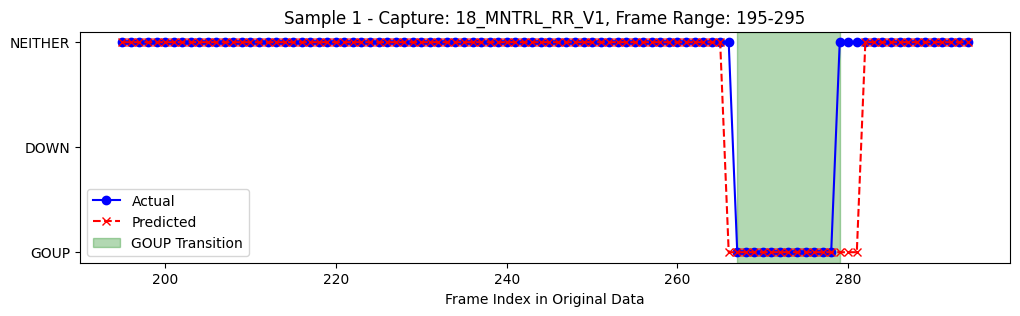

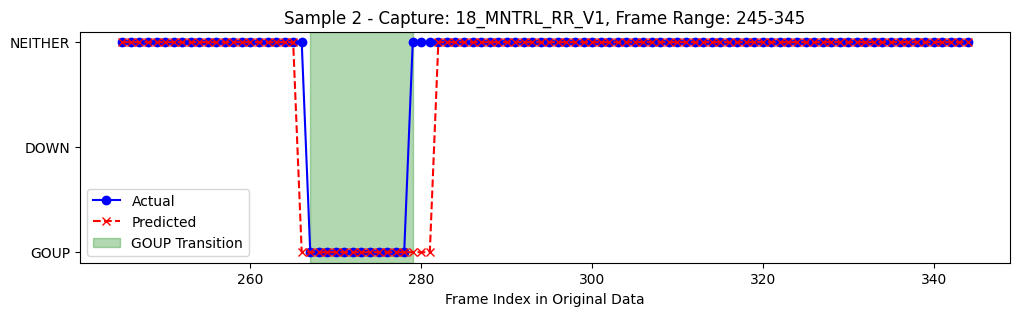

In [43]:
import matplotlib.pyplot as plt
import torch

def visualize_timeline(sample_data, model, actual_labels, lengths, metadata):
    model.eval()
    with torch.no_grad():
        # Assuming your model outputs logits that need softmax
        predictions = model(sample_data, lengths)
        predictions = torch.softmax(predictions, dim=-1)
        predicted_labels = torch.argmax(predictions, dim=-1)

    # Visualizing timelines for the first few samples in the batch
    num_samples_to_visualize = 5  # Adjust based on how many samples you want to visualize
    for i in range(min(num_samples_to_visualize, sample_data.size(0))):
        plt.figure(figsize=(12, 3))
        
        # Mapping frame indices to the actual frame range in the original data
        actual_frame_indices = [metadata[i]['frame_range'][0] + j for j in range(lengths[i].item())]
        
        actual = actual_labels[i][:lengths[i]].cpu().numpy()
        predicted = predicted_labels[i][:lengths[i]].cpu().numpy()
        
        # Plot actual vs predicted
        plt.plot(actual_frame_indices, actual, label='Actual', marker='o', linestyle='-', color='blue')
        plt.plot(actual_frame_indices, predicted, label='Predicted', linestyle='--', marker='x', color='red')
        
        # Highlight GOUP and DOWN ranges
        for goup_range in metadata[i]['GOUP_ranges']:
            plt.axvspan(goup_range[0]+metadata[i]['frame_range'][0], goup_range[1]+metadata[i]['frame_range'][0], color='green', alpha=0.3, label='GOUP Transition')
        for down_range in metadata[i]['DOWN_ranges']:
            plt.axvspan(down_range[0]+metadata[i]['frame_range'][0], down_range[1]+metadata[i]['frame_range'][0], color='red', alpha=0.3, label='DOWN Transition')
        
        # Set y-ticks and labels
        plt.yticks([0, 1, 2], ['GOUP', 'DOWN', 'NEITHER'])
        plt.xlabel('Frame Index in Original Data')
        
        # Include metadata in title or annotations
        frame_range_str = f"{metadata[i]['frame_range'][0]}-{metadata[i]['frame_range'][1]}"
        meta_info = f"Capture: {metadata[i]['RADAR_capture']}, Frame Range: {frame_range_str}"
        plt.title(f'Sample {i+1} - {meta_info}')
        
        # Only display unique labels in legend
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # Removing duplicate labels
        plt.legend(by_label.values(), by_label.keys())
        plt.show()

# Fetch a batch from the test data loader
batch_data, batch_labels, batch_lengths, batch_metadata = next(iter(test_loader))

# Visualize the timeline for samples in the batch with metadata
visualize_timeline(batch_data, model, batch_labels, batch_lengths, batch_metadata)


SMOOTHED VIZUALIZATION

/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmDataset.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = pad_sequence([torch.tensor(seq, dtype=torch.float) for seq in sequences], batch_first=True)


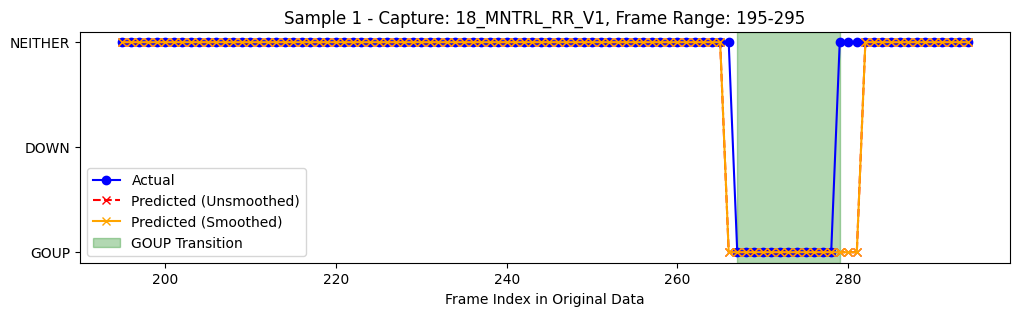

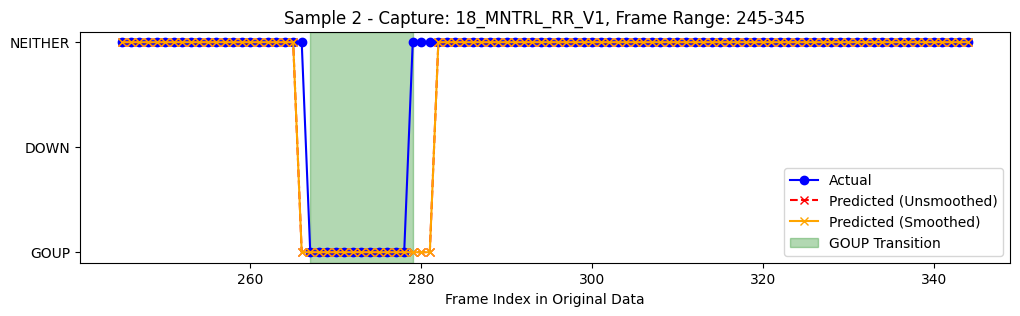

In [44]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def smooth_predictions(predictions, window_size=5):
    # Apply moving average with a window of size `window_size`
    smoothed = np.convolve(predictions, np.ones(window_size)/window_size, mode='same')
    return smoothed

def visualize_timeline(sample_data, model, actual_labels, lengths, metadata, window_size=5):
    model.eval()
    with torch.no_grad():
        # Assuming your model outputs logits that need softmax
        predictions = model(sample_data, lengths)
        probabilities = torch.softmax(predictions, dim=-1).cpu().numpy()

    # Visualizing timelines for the first few samples in the batch
    num_samples_to_visualize = 5  # Adjust based on how many samples you want to visualize
    for i in range(min(num_samples_to_visualize, sample_data.size(0))):
        plt.figure(figsize=(12, 3))
        
        # Mapping frame indices to the actual frame range in the original data
        actual_frame_indices = [metadata[i]['frame_range'][0] + j for j in range(lengths[i].item())]
        
        actual = actual_labels[i][:lengths[i]].cpu().numpy()

        # Smooth probabilities for each class and determine the class with the highest probability after smoothing
        smoothed_probabilities = np.apply_along_axis(lambda m: smooth_predictions(m, window_size=window_size), axis=0, arr=probabilities[i][:lengths[i]])
        smoothed_predictions = np.argmax(smoothed_probabilities, axis=1)
        
        predicted = torch.argmax(predictions[i][:lengths[i]], dim=-1).cpu().numpy()  # Original (unsmoothed) predictions
        
        # Plot actual vs predicted
        plt.plot(actual_frame_indices, actual, label='Actual', marker='o', linestyle='-', color='blue')
        plt.plot(actual_frame_indices, predicted, label='Predicted (Unsmoothed)', linestyle='--', marker='x', color='red')
        plt.plot(actual_frame_indices, smoothed_predictions, label='Predicted (Smoothed)', linestyle='-', marker='x', color='orange')

        # Highlight GOUP and DOWN ranges
        for goup_range in metadata[i]['GOUP_ranges']:
            plt.axvspan(goup_range[0]+metadata[i]['frame_range'][0], goup_range[1]+metadata[i]['frame_range'][0], color='green', alpha=0.3, label='GOUP Transition')
        for down_range in metadata[i]['DOWN_ranges']:
            plt.axvspan(down_range[0]+metadata[i]['frame_range'][0], down_range[1]+metadata[i]['frame_range'][0], color='red', alpha=0.3, label='DOWN Transition')
        
        # Set y-ticks and labels
        plt.yticks([0, 1, 2], ['GOUP', 'DOWN', 'NEITHER'])
        plt.xlabel('Frame Index in Original Data')
        
        # Include metadata in title or annotations
        frame_range_str = f"{metadata[i]['frame_range'][0]}-{metadata[i]['frame_range'][1]}"
        meta_info = f"Capture: {metadata[i]['RADAR_capture']}, Frame Range: {frame_range_str}"
        plt.title(f'Sample {i+1} - {meta_info}')
        
        # Only display unique labels in legend
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))  # Removing duplicate labels
        plt.legend(by_label.values(), by_label.keys())
        plt.show()

# Fetch a batch from the test data loader
batch_data, batch_labels, batch_lengths, batch_metadata = next(iter(test_loader))

# Visualize the timeline for samples in the batch with metadata and smoothed predictions
visualize_timeline(batch_data, model, batch_labels, batch_lengths, batch_metadata, window_size=5)


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmDataset.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = pad_sequence([torch.tensor(seq, dtype=torch.float) for seq in sequences], batch_first=True)


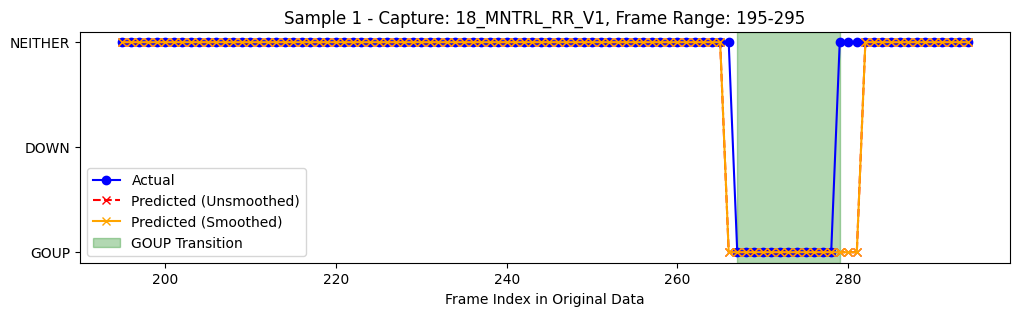

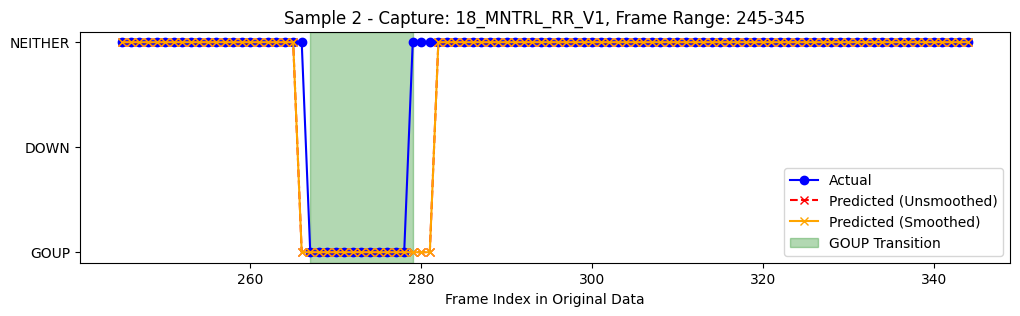

/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmDataset.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = pad_sequence([torch.tensor(seq, dtype=torch.float) for seq in sequences], batch_first=True)


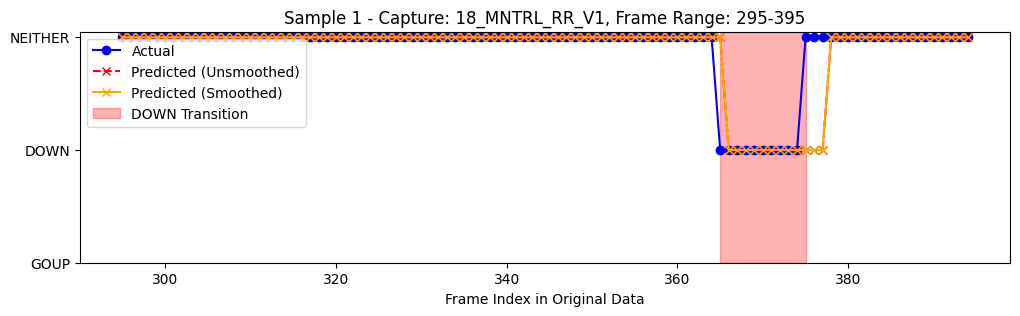

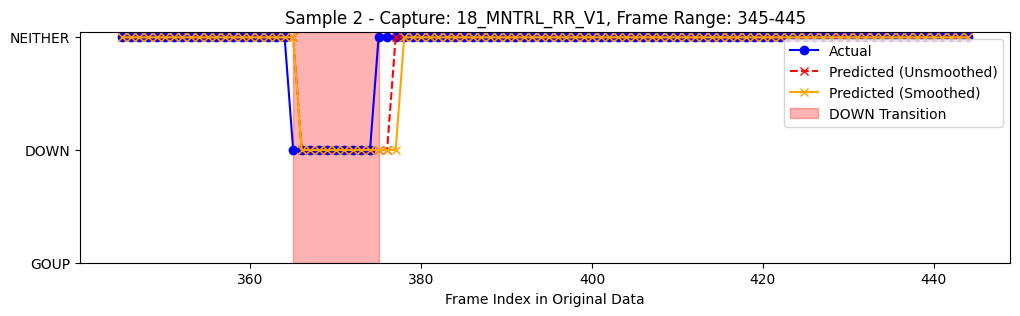

/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmDataset.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = pad_sequence([torch.tensor(seq, dtype=torch.float) for seq in sequences], batch_first=True)


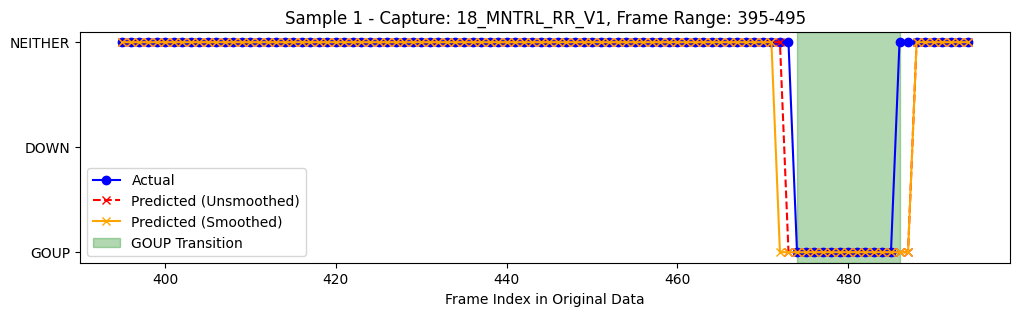

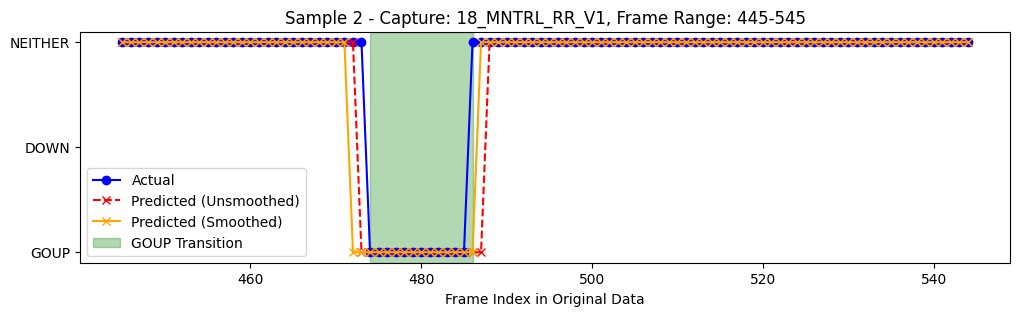

/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmDataset.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = pad_sequence([torch.tensor(seq, dtype=torch.float) for seq in sequences], batch_first=True)


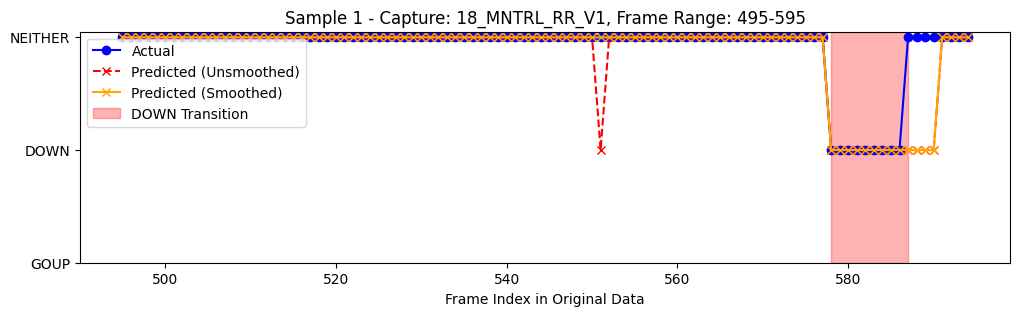

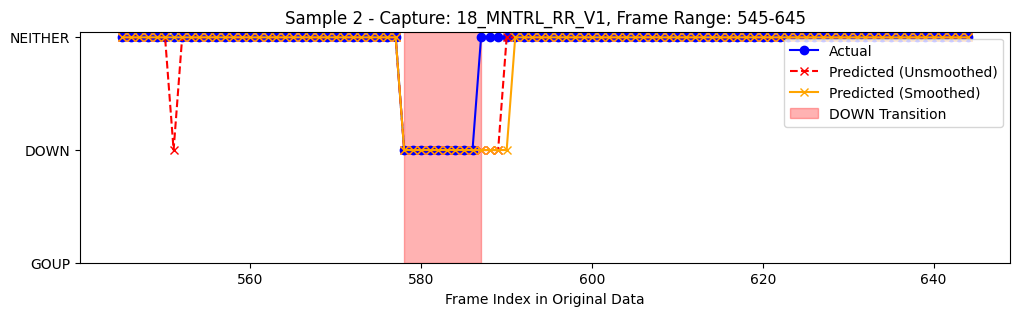

/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmDataset.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = pad_sequence([torch.tensor(seq, dtype=torch.float) for seq in sequences], batch_first=True)


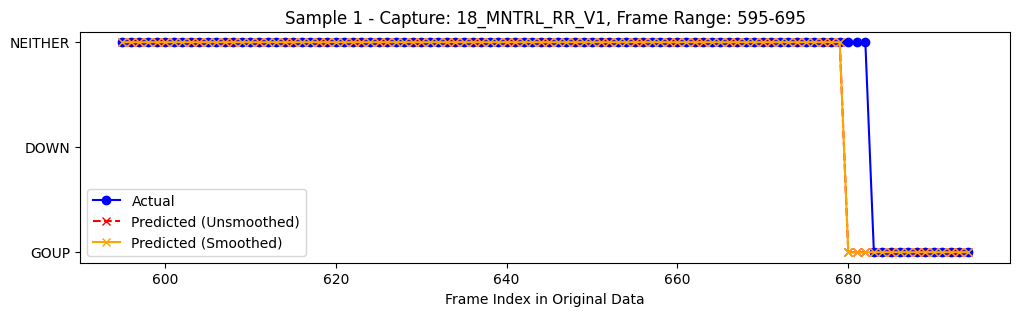

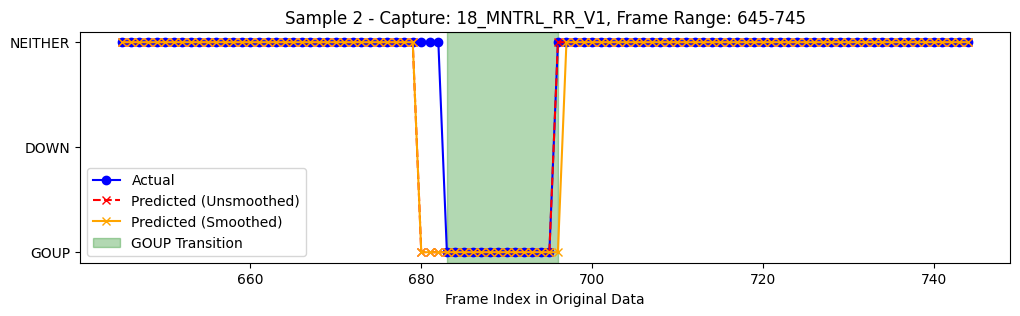

In [45]:
import matplotlib.pyplot as plt
import torch

# Assuming the visualize_timeline function is defined as previously discussed

# Fetch and visualize timelines for 20 batches from the test data loader
num_batches_to_visualize = 5
batch_counter = 0

for batch_data, batch_labels, batch_lengths, batch_metadata in test_loader:
    visualize_timeline(batch_data, model, batch_labels, batch_lengths, batch_metadata)
    
    batch_counter += 1
    if batch_counter >= num_batches_to_visualize:
        break


Predict for a full length capture

load full length captures

In [ ]:
import torch
import numpy as np
from scipy.signal import convolve

def smooth_predictions(predictions, window_size=5):
    """Smooth predictions with a moving average filter."""
    window = np.ones(window_size) / window_size
    smoothed = convolve(predictions, window, mode='same') / convolve(np.ones_like(predictions), window, mode='same')
    return smoothed

def evaluate_capture_with_overlap(model, dataset, window_size=100, step_size=50, smooth_window=5):
    model.eval()
    full_length_predictions = np.zeros((len(dataset), dataset[0][0].size(1), 3)) # Adjust for the number of classes

    with torch.no_grad():
        for i in range(0, len(dataset), step_size):
            # Adjust to handle the end of the dataset
            end_idx = min(i + window_size, len(dataset))
            batch_data, _, batch_lengths, _ = dataset[i:end_idx] # Assuming dataset returns a batch

            # Ensure input tensor shape is correct for model input
            batch_data = batch_data.unsqueeze(0).float()
            outputs = model(batch_data)
            probabilities = torch.softmax(outputs, dim=2)
            predicted_labels = torch.argmax(probabilities, dim=2)

            # Fill in the predictions, averaging overlaps
            for j in range(i, end_idx):
                start_overlap = max(0, j - i)
                end_overlap = min(window_size, len(dataset) - j)
                full_length_predictions[j, :, :] += predicted_labels[0, start_overlap:end_overlap, :].cpu().numpy()

    # Average the overlaps by dividing by the overlap count (2 for all but the ends)
    overlap_count = np.full(full_length_predictions.shape, 2) # Assuming constant overlap count, adjust if varying
    overlap_count[0:step_size, :, :] = 1  # No overlap at the start
    overlap_count[-step_size:, :, :] = 1  # No overlap at the end
    averaged_predictions = full_length_predictions / overlap_count

    # Smooth the predictions
    smoothed_predictions = np.apply_along_axis(smooth_predictions, 0, averaged_predictions, window_size=smooth_window)

    return smoothed_predictions

# Assuming your dataset can provide sliding window batches directly
# Here dataset should be a custom dataset or mechanism to iterate over your data with the sliding window and overlap
smoothed_predictions = evaluate_capture_with_overlap(model, test_dataset)

# smoothed_predictions now contains the smoothed, averaged class predictions for each frame in the capture


Individual transition predictions

In [ ]:
def apply_threshold(smoothed_probabilities, threshold=0.5):
    # Apply threshold to smoothed probabilities for each class
    goup_event_detected = smoothed_probabilities[:, 0] > threshold  # Assuming class 0 is GOUP
    down_event_detected = smoothed_probabilities[:, 1] > threshold  # Assuming class 1 is DOWN
    
    return goup_event_detected, down_event_detected

def find_event_transitions(event_detected):
    # Find indices where transitions occur
    transitions = np.diff(event_detected.astype(int)) == 1
    event_locations = np.where(transitions)[0] + 1  # Add 1 to correct index after diff
    
    return event_locations

def evaluate_predictions(goup_event_locations, down_event_locations, ground_truth_goup_locations, ground_truth_down_locations, tolerance=10):
    correct_goup_predictions = sum(
        any(abs(event_location - gt_location) <= tolerance for event_location in goup_event_locations)
        for gt_location in ground_truth_goup_locations
    )
    correct_down_predictions = sum(
        any(abs(event_location - gt_location) <= tolerance for event_location in down_event_locations)
        for gt_location in ground_truth_down_locations
    )
    
    return correct_goup_predictions, correct_down_predictions

In [ ]:

# Assuming 'probabilities' is a 2D array with shape (num_frames, 3) containing the probabilities for NEITHER, GOUP, and DOWN in each row
smoothed_probabilities = np.apply_along_axis(lambda m: smooth_predictions(m, window_size=5), axis=0, arr=probabilities)
goup_detected, down_detected = apply_threshold(smoothed_probabilities, threshold=0.5)

goup_event_locations = find_event_transitions(goup_detected)
down_event_locations = find_event_transitions(down_detected)

# Example ground truth locations for GOUP and DOWN events
ground_truth_goup_locations = [100, 500]
ground_truth_down_locations = [250, 750]

correct_goup_predictions, correct_down_predictions = evaluate_predictions(
    goup_event_locations, down_event_locations, ground_truth_goup_locations, ground_truth_down_locations, tolerance=10
)

print(f"Correct GOUP Predictions: {correct_goup_predictions} out of {len(ground_truth_goup_locations)}")
print(f"Correct DOWN Predictions: {correct_down_predictions} out of {len(ground_truth_down_locations)}")